In [ ]:
from fastai.text.all import *

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

(#7) [Path('~/.fastai/data/imdb/test'),Path('~/.fastai/data/imdb/tmp_clas'),Path('~/.fastai/data/imdb/README'),Path('~/.fastai/data/imdb/unsup'),Path('~/.fastai/data/imdb/train'),Path('~/.fastai/data/imdb/tmp_lm'),Path('~/.fastai/data/imdb/imdb.vocab')]

In [ ]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [ ]:
learn.model[0].module.encoder

Embedding(60008, 400, padding_idx=1)

In [ ]:
keys=L('woman','carpenter','engineer','mechanic','housekeeper','dancer','secretary','librarian','nurse','man')

In [ ]:
idxs=keys.map(lambda k: learn.dls.o2i[k])

In [ ]:
learn.model[0].module.encoder(torch.tensor(idxs)).shape

torch.Size([10, 400])

In [ ]:
embeds=learn.model[0].module.encoder(torch.tensor(idxs))
embeds

tensor([[-5.6244e-02,  1.6333e-01,  8.1482e-03,  ..., -2.1021e-01,
         -4.3884e-02,  2.6840e-02],
        [ 5.0011e-03, -2.4582e-02, -8.0627e-02,  ...,  9.7351e-03,
         -1.1536e-02, -1.6943e-01],
        [-3.3789e-01, -1.1261e-01, -6.9153e-02,  ..., -2.4805e-01,
          2.6660e-01,  1.1414e-01],
        ...,
        [-1.8640e-01, -2.7649e-02, -1.0931e-01,  ..., -4.0436e-02,
          1.7310e-01, -8.8623e-02],
        [-1.3391e-01, -6.0486e-02, -1.1761e-01,  ...,  5.6686e-03,
         -5.0385e-02,  9.8877e-02],
        [-6.3477e-02,  4.0405e-01, -2.2803e-01,  ..., -1.3135e-01,
         -3.7360e-04,  3.2471e-01]])

In [ ]:
similarity=F.cosine_similarity(embeds[:,None].repeat(1,embeds.shape[0],1),embeds[None].repeat(embeds.shape[0],1,1),dim=2)

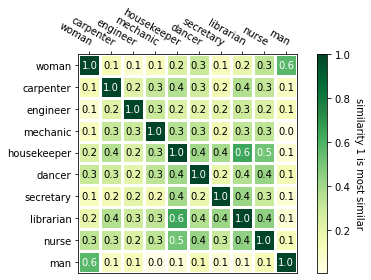

In [ ]:
fig, ax = plt.subplots()

im, cbar = heatmap(similarity.numpy(), list(keys), list(keys), ax=ax,
                   cmap="YlGn", cbarlabel="similarity 1 is most similar")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
dls.show_batch()

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxrep 3 * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . xxrep 3 * \n\n xxmaj before i begin , xxmaj i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that - you - fall - over - laughing movies . xxmaj if you 're in a lighthearted mood and need a very hearty laugh , this is the movie for you . xxmaj now without further ado , my review : \n\n xxmaj this movie was found in a bargain bin at wal - mart . xxmaj that should be the first clue as to how good of a movie it is . xxmaj secondly , it stars the lame action",neg
2,"xxbos xxmaj this movie was recently released on xxup dvd in the xxup us and i finally got the chance to see this hard - to - find gem . xxmaj it even came with original theatrical previews of other xxmaj italian horror classics like "" xxunk "" and "" beyond xxup the xxup darkness "" . xxmaj unfortunately , the previews were the best thing about this movie . \n\n "" zombi 3 "" in a bizarre way is actually linked to the infamous xxmaj lucio xxmaj fulci "" zombie "" franchise which began in 1979 . xxmaj similarly compared to "" zombie "" , "" zombi 3 "" consists of a threadbare plot and a handful of extremely bad actors that keeps this ' horror ' trash barely afloat . xxmaj the gore is nearly non - existent ( unless one is frightened of people running around with",neg
3,"xxbos xxmaj heavy - handed moralism . xxmaj writers using characters as mouthpieces to speak for themselves . xxmaj predictable , plodding plot points ( say that five times fast ) . a child 's imitation of xxmaj britney xxmaj spears . xxmaj this film has all the earmarks of a xxmaj lifetime xxmaj special reject . \n\n i honestly believe that xxmaj jesus xxmaj xxunk and xxmaj julia xxmaj xxunk set out to create a thought - provoking , emotional film on a tough subject , exploring the idea that things are not always black and white , that one who is a criminal by definition is not necessarily a bad human being , and that there can be extenuating circumstances , especially when one puts the well - being of a child first . xxmaj however , their earnestness ends up being channeled into preachy dialogue and trite",neg
4,"xxbos xxmaj okay , so xxmaj i 'm not a big video game buff , but was the game xxmaj house of the xxmaj dead really famous enough to make a movie from ? xxmaj sure , they went as far as to actually put in quick video game clips throughout the movie , as though justifying any particular scene of violence , but there are dozens and dozens of games that look exactly the same , with the hand in the bottom on the screen , supposedly your own , holding whatever weapon and goo - ing all kinds of aliens or walking dead or snipers or whatever the case may be . \n\n xxmaj it 's an interesting premise in xxmaj house of the xxmaj dead , with a lot of college kids ( loaded college kids , as it were , kids who are able to pay",neg
5,"xxbos xxmaj director xxmaj douglas xxmaj sirk once said ` there 's a very short distance between high art and trash , and trash that

In [ ]:
path_sample=untar_data(URLs.IMDB_SAMPLE)

In [ ]:
path_sample.ls()

(#1) [Path('~/.fastai/data/imdb_sample/texts.csv')]

In [ ]:
table=pd.read_csv(path_sample.ls()[0])

In [ ]:
table

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False
...,...,...,...
995,negative,"There are many different versions of this one floating around, so make sure you can locate one of the unrated copies, otherwise some gore and one scene of nudity might be missing. Some versions also omit most of the opening sequence and other bits here and there. The cut I saw has the on-screen title WITCHCRAFT: EVIL ENCOUNTERS and was released by Shriek Show, who maintain the original US release title WITCHERY for the DVD release. It's a nice-looking print and seems to have all of the footage, but has some cropping/aspect ratio issues. In Italy, it was released as LA CASA 4 (WITCHCRAFT). ...",True
996,positive,"Once upon a time Hollywood produced live-action, G-rated movies without foul language, immorality, and gore-splattered violence. These movies neither insulted your intelligence no manipulated your emotions. The heroes differed little from the crowd. They shared the same feelings and bore the same burdens. Since the 1970s, the film industry has pretty much written off G-rated movies for adults. Basically, modern mature audi

In [ ]:
[[l1,l2] for (l1,l2) in table[['label','label']].items()]

[['label',
  0      negative
  1      positive
  2      negative
  3      positive
  4      negative
           ...   
  995    negative
  996    positive
  997    negative
  998    negative
  999    positive
  Name: label, Length: 1000, dtype: object],
 ['label',
  0      negative
  1      positive
  2      negative
  3      positive
  4      negative
           ...   
  995    negative
  996    positive
  997    negative
  998    negative
  999    positive
  Name: label, Length: 1000, dtype: object]]

In [ ]:
pd.array([l], dtype="string")

In [ ]:
table['combined']=table[['label','text']].values.tolist()

In [ ]:
table

,label,text,is_valid,combined
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False,"[negative, Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!]"
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False,"[positive, This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. T..."
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False,"[negative, Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that..."
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False,"[positive, Name just says it all. I watched this movie with m

In [ ]:
def concat_string_columns(table,columns):
    n_cols=len(columns)
    def concat_labels(column):
        return column.apply(lambda l: pd.arrays.StringArray(pd.array([l], dtype="string")))
    return table[columns].apply(concat_labels).sum(axis=1)

In [ ]:
concat_string_columns(table,['label','text'])

0                                                                                                                                                                                              [negativeUn-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!]
1      [positiveThis is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because 

In [ ]:
table[['label','text']].apply(lambda (l1,:pd.arrays.StringArray(pd.array([l], dtype="string")))

ValueError: If using all scalar values, you must pass an index

In [ ]:
table

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False
...,...,...,...
995,negative,"There are many different versions of this one floating around, so make sure you can locate one of the unrated copies, otherwise some gore and one scene of nudity might be missing. Some versions also omit most of the opening sequence and other bits here and there. The cut I saw has the on-screen title WITCHCRAFT: EVIL ENCOUNTERS and was released by Shriek Show, who maintain the original US release title WITCHERY for the DVD release. It's a nice-looking print and seems to have all of the footage, but has some cropping/aspect ratio issues. In Italy, it was released as LA CASA 4 (WITCHCRAFT). ...",True
996,positive,"Once upon a time Hollywood produced live-action, G-rated movies without foul language, immorality, and gore-splattered violence. These movies neither insulted your intelligence no manipulated your emotions. The heroes differed little from the crowd. They shared the same feelings and bore the same burdens. Since the 1970s, the film industry has pretty much written off G-rated movies for adults. Basically, modern mature audi